In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import seaborn as sns
import os
import csv

import cv2

from glob import glob
from matplotlib.patches import  Polygon
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
from scipy.stats import linregress
from scipy.spatial.distance import cdist
from scipy.linalg import polar

import sys
sys.path.insert(0, "..")

from utils import geometry
from utils import fileio

In [4]:
dat_files=sorted(glob('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/Unstretched_data/20231012_2_IP_GFPCAAX-CheHis_uu_0p5/*/*/Data/*_cell_data_all*.csv'))
mat_dir=sorted(glob('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/Unstretched_data/20231012_2_IP_GFPCAAX-CheHis_uu_0p5/*/*/Matrices'))
save_folder='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/'
plot_dir = 'C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/Unstretched_plots/20231012_2_IP_GFPCAAX-CheHis_uu_0p5/'

In [5]:
micron_size=553.57
pixel_size=1024

In [6]:
tm_spot_dat=pd.read_csv('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\unstretched/Tracked/20231012_2_IP_GFPCAAX-CheHis_uu_0p5_SP/5min_int/traces/green_edges/tm_spots.csv', skiprows=[1,2,3])
tm_track_dat=pd.read_csv('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\unstretched/Tracked/20231012_2_IP_GFPCAAX-CheHis_uu_0p5_SP/5min_int/traces/green_edges/tm_tracks.csv', skiprows=[1,2,3])
tm_edge_dat=pd.read_csv('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\unstretched/Tracked/20231012_2_IP_GFPCAAX-CheHis_uu_0p5_SP/5min_int/traces/green_edges/tm_edges.csv', skiprows=[1,2,3])



cols=['cell_id', 'cell_perimeter_microns', 'cell_area_microns',
       'shape_parameter', 'circularity', 'cell_edge_count',
       'major_shape_axis_alignment_rads', 'cc_x', 'cc_y', 'track_id', 'spot_id', 'time', 'tm_frame']
dat_df=pd.DataFrame(columns=cols)
for i in range(len(dat_files)):
    tm=tm_spot_dat[tm_spot_dat.FRAME==i][['ID','TRACK_ID', 'POSITION_X', 'POSITION_Y', 'FRAME']]

    A=np.loadtxt(glob(mat_dir[i]+'/*Matrix_A*.txt')[0])
    B=np.loadtxt(glob(mat_dir[i]+'/*Matrix_B*.txt')[0])
    C=np.loadtxt(glob(mat_dir[i]+'/*Matrix_C*.txt')[0])
    R=np.loadtxt(glob(mat_dir[i]+'/*Matrix_R*.txt')[0])

    dat=pd.read_csv(dat_files[i])

    cell_edge_count=geometry.get_edge_count(B)
    cell_centres=geometry.get_cell_centres(C,R,cell_edge_count)


    scale_factor=1.03

    cc=np.vstack((cell_centres[:,0]-np.mean(cell_centres[:,0]),cell_centres[:,1]-np.mean(cell_centres[:,1]))).T
    tm_cc=scale_factor*np.vstack((tm.POSITION_X-np.mean(tm.POSITION_X), -tm.POSITION_Y-np.mean(-tm.POSITION_Y))).T

    # plt.scatter(cc[:,0], cc[:,1])
    # plt.scatter(tm_cc[:,0], tm_cc[:,1])
    # plt.title(str(i))
    # plt.show()

    dists=cdist(cc, tm_cc)
    min_id=np.where(dists==np.min(dists, axis=0))[1]

    dat['cc_x']=cc[:,0]
    dat['cc_y']=cc[:,1]
    dat['track_id']=np.array(tm.TRACK_ID.iloc[min_id])
    dat['spot_id']=np.array(tm.ID.iloc[min_id])
    dat['tm_frame']=np.array(tm.FRAME.iloc[min_id])
    dat['time']=dat['tm_frame']*5
    


    dat_df=pd.concat([dat_df,dat], ignore_index=True)


dat_df["parent_id"] = np.nan
dat_df["divisions"] = 0

t_id=np.max(dat_df.track_id)
Nc_orig=t_id
max_splits=np.max(tm_track_dat.NUMBER_SPLITS)


for s in tm_track_dat[tm_track_dat.NUMBER_SPLITS>0].TRACK_ID:

    
    splits=np.array(tm_track_dat[tm_track_dat.TRACK_ID==s].NUMBER_SPLITS)[0]

    split=np.where(np.unique(dat_df[dat_df.track_id==s].tm_frame,return_counts=True)[1]>1)[0][0]


    edges=tm_edge_dat[tm_edge_dat.TRACK_ID==s]
    n_edges=edges[edges.EDGE_TIME==split-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
    track_a=[]
    track_b=[]
    track_a.append(n_edges.SPOT_TARGET_ID.iloc[0])
    track_b.append(n_edges.SPOT_TARGET_ID.iloc[1])
    
    for i in range(split+1,len(dat_files)):
        n_edges=edges[edges.EDGE_TIME==i-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
        t_a=list(n_edges[n_edges.SPOT_SOURCE_ID.isin(track_a)].SPOT_TARGET_ID)
        t_b=list(n_edges[n_edges.SPOT_SOURCE_ID.isin(track_b)].SPOT_TARGET_ID)
        track_a=track_a+t_a
        track_b=track_b+t_b
    
    new_id_a=t_id+1
    new_id_b=t_id+2

    dat_df.loc[dat_df["spot_id"].isin(track_a), "track_id"]=new_id_a
    dat_df.loc[dat_df["spot_id"].isin(track_b), "track_id"]=new_id_b
    dat_df.loc[(dat_df["spot_id"].isin(track_a))|(dat_df["spot_id"].isin(track_b)), "parent_id"]=s
    dat_df.loc[(dat_df["spot_id"].isin(track_a))|(dat_df["spot_id"].isin(track_b)), "divisions"]+=1
    tm_edge_dat.loc[tm_edge_dat["SPOT_SOURCE_ID"].isin(track_a), "TRACK_ID"]=new_id_a
    tm_edge_dat.loc[tm_edge_dat["SPOT_SOURCE_ID"].isin(track_b), "TRACK_ID"]=new_id_b




    t_id=t_id+2

    if splits>1:
        if(len(np.where(np.unique(dat_df[dat_df.track_id==new_id_a].tm_frame,return_counts=True)[1]>1)[0])>0):
                split=np.unique(dat_df[dat_df.track_id==new_id_a].tm_frame,return_counts=True)[0][np.where(np.unique(dat_df[dat_df.track_id==new_id_a].tm_frame,return_counts=True)[1]>1)[0][0]]

                edges=tm_edge_dat[tm_edge_dat.TRACK_ID==new_id_a]
                n_edges=edges[edges.EDGE_TIME==split-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
                track_a=[]
                track_b=[]
                track_a.append(n_edges.SPOT_TARGET_ID.iloc[0])
                track_b.append(n_edges.SPOT_TARGET_ID.iloc[1])

                for i in range(split+1,len(dat_files)):
                    n_edges=edges[edges.EDGE_TIME==i-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
                    t_a=list(n_edges[n_edges.SPOT_SOURCE_ID.isin(track_a)].SPOT_TARGET_ID)
                    t_b=list(n_edges[n_edges.SPOT_SOURCE_ID.isin(track_b)].SPOT_TARGET_ID)
                    track_a=track_a+t_a
                    track_b=track_b+t_b

                new_id_aa=t_id+1
                new_id_bb=t_id+2

                dat_df.loc[dat_df["spot_id"].isin(track_a), "track_id"]=new_id_aa
                dat_df.loc[dat_df["spot_id"].isin(track_b), "track_id"]=new_id_bb
                dat_df.loc[(dat_df["spot_id"].isin(track_a))|(dat_df["spot_id"].isin(track_b)), "parent_id"]=new_id_a
                dat_df.loc[(dat_df["spot_id"].isin(track_a))|(dat_df["spot_id"].isin(track_b)), "divisions"]+=1
                tm_edge_dat.loc[tm_edge_dat["SPOT_SOURCE_ID"].isin(track_a), "TRACK_ID"]=new_id_aa
                tm_edge_dat.loc[tm_edge_dat["SPOT_SOURCE_ID"].isin(track_b), "TRACK_ID"]=new_id_bb

                t_id=t_id+2

        if(len(np.where(np.unique(dat_df[dat_df.track_id==new_id_b].tm_frame,return_counts=True)[1]>1)[0]) >0):
                split=np.unique(dat_df[dat_df.track_id==new_id_b].tm_frame,return_counts=True)[0][np.where(np.unique(dat_df[dat_df.track_id==new_id_b].tm_frame,return_counts=True)[1]>1)[0][0]]

                edges=tm_edge_dat[tm_edge_dat.TRACK_ID==new_id_b]
                n_edges=edges[edges.EDGE_TIME==split-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
                track_a=[]
                track_b=[]
                track_a.append(n_edges.SPOT_TARGET_ID.iloc[0])
                track_b.append(n_edges.SPOT_TARGET_ID.iloc[1])

                for i in range(split+1,len(dat_files)):
                    n_edges=edges[edges.EDGE_TIME==i-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
                    t_a=list(n_edges[n_edges.SPOT_SOURCE_ID.isin(track_a)].SPOT_TARGET_ID)
                    t_b=list(n_edges[n_edges.SPOT_SOURCE_ID.isin(track_b)].SPOT_TARGET_ID)
                    track_a=track_a+t_a
                    track_b=track_b+t_b

                new_id_aa=t_id+1
                new_id_bb=t_id+2

                dat_df.loc[dat_df["spot_id"].isin(track_a), "track_id"]=new_id_aa
                dat_df.loc[dat_df["spot_id"].isin(track_b), "track_id"]=new_id_bb
                dat_df.loc[(dat_df["spot_id"].isin(track_a))|(dat_df["spot_id"].isin(track_b)), "parent_id"]=new_id_b
                dat_df.loc[(dat_df["spot_id"].isin(track_a))|(dat_df["spot_id"].isin(track_b)), "divisions"]+=1
                tm_edge_dat.loc[tm_edge_dat["SPOT_SOURCE_ID"].isin(track_a), "TRACK_ID"]=new_id_aa
                tm_edge_dat.loc[tm_edge_dat["SPOT_SOURCE_ID"].isin(track_b), "TRACK_ID"]=new_id_bb

                t_id=t_id+2

dat_df=dat_df.rename(columns={"cell_id": "cell_id_old", "track_id": "cell_id_new"})
dat_df['angle_horizontal']=abs(np.where(dat_df.major_shape_axis_alignment_rads<np.pi/2,dat_df.major_shape_axis_alignment_rads, dat_df.major_shape_axis_alignment_rads-np.pi))
dat_df['cc_x']=dat_df['cc_x']*(micron_size/pixel_size)
dat_df['cc_y']=dat_df['cc_y']*(micron_size/pixel_size)
dat_df.to_csv(save_folder+"/20231012_2_IP_GFPCAAX-CheHis_uu_0p5_SP_pooled_mech.csv",index=False)

In [22]:
dat_df=dat_df.sort_values(['time', 'cell_id_new']).reset_index(drop=True)
dat_df['area_norm']=dat_df.cell_area_microns/(dat_df.groupby('cell_id_new').cell_area_microns.transform('first'))
dat_df['perimeter_norm']=dat_df.cell_perimeter_microns/(dat_df.groupby('cell_id_new').cell_perimeter_microns.transform('first'))
dat_df['circularity_norm']=dat_df.circularity/(dat_df.groupby('cell_id_new').circularity.transform('first'))

In [52]:
orig_cells=dat_df[dat_df.cell_id_new<=Nc_orig]

div_list=np.unique(dat_df.parent_id)[~np.isnan(np.unique(dat_df.parent_id))]

#no_div=orig_cells[~orig_cells.cell_id_new.isin(np.where(tm_track_dat.NUMBER_SPLITS>0)[0])]
no_div=dat_df[dat_df.cell_id_new.isin(np.where(dat_df.groupby('cell_id_new').count().time==len(dat_files))[0])]



div_cells=dat_df[(dat_df.cell_id_new.isin(div_list))]
daughter_cells=dat_df[dat_df.cell_id_new>Nc_orig]

In [48]:
np.unique(dat_df.parent_id)[~np.isnan(np.unique(dat_df.parent_id))]

array([ 78., 103., 120., 121., 126., 146., 179., 209., 218., 334., 339.,
       354., 371., 394., 406., 424.])

In [24]:
cell_dat=dat_df.groupby('cell_id_new').min().time.to_frame()
dat_mi=dat_df.set_index(['cell_id_new','time'])
dat_mi['dx0']=dat_mi.cc_x-dat_df.groupby('cell_id_new').first().cc_x
dat_mi['dy0']=dat_mi.cc_y-dat_df.groupby('cell_id_new').first().cc_y
dat_mi['ds0']=np.sqrt(dat_mi.dx0**2 +dat_mi.dy0**2)
dat_mi['ds0_sq']=dat_mi.dx0**2 +dat_mi.dy0**2
cell_dat['MSD']=dat_mi.groupby('cell_id_new').mean().ds0_sq

C:\Users\v35431nc\AppData\Local\Temp\ipykernel_33396\3339878596.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cell_dat['MSD']=dat_mi.groupby('cell_id_new').mean().ds0_sq


C:\Users\v35431nc\AppData\Local\Temp\ipykernel_33396\4028117221.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g=sns.histplot(data=cell_dat,x='MSD', stat='probability',element="step", palette=sns.husl_palette(1,l=.4))


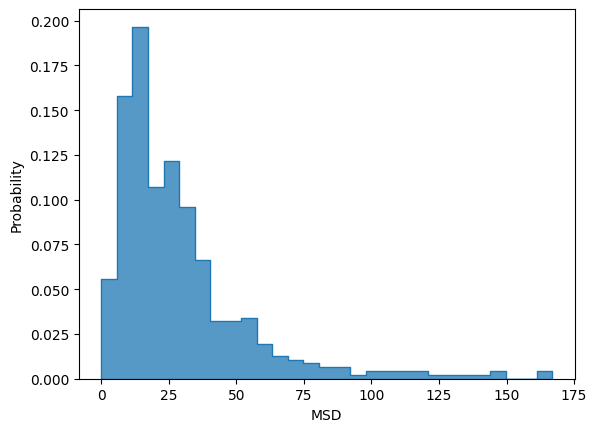

In [25]:
fig, ax=plt.subplots()
g=sns.histplot(data=cell_dat,x='MSD', stat='probability',element="step", palette=sns.husl_palette(1,l=.4))


plt.savefig(plot_dir+'/MSD.png', dpi=300, bbox_inches='tight')

In [50]:
dat_mi

,,cell_id_old,cell_perimeter_microns,cell_area_microns,shape_parameter,circularity,cell_edge_count,major_shape_axis_alignment_rads,cc_x,cc_y,spot_id,tm_frame,parent_id,divisions,angle_horizontal,area_norm,perimeter_norm,circularity_norm,dx0
cell_id_new,time,,,,,,,,,,,,,,,,,,
0,0,97.0,72.172974,342.299744,3.900958,0.818032,5.0,0.240503,272.727313,130.281342,3491,0,NaN,0,0.240503,1.000000,1.000000,1.000000,0.000000
1,0,350.0,83.526673,497.930465,3.743181,0.474316,7.0,2.698412,-186.158402,-119.375801,5141,0,NaN,0,0.443181,1.000000,1.000000,1.000000,0.000000
2,0,185.0,73.870311,376.705406,3.806002,0.740600,6.0,0.311762,-107.206021,-123.018658,5131,0,NaN,0,0.311762,1.000000,1.000000,1.000000,0.000000
3,0,429.0,101.522818,738.916512,3.734788,0.735775,8.0,1.436113,-211.247687,113.481342,3503,0,NaN,0,1.436113,1.000000,1.000000,1.000000,0.000000
4,0,186.0,64.218410,293.692594,3.747253,0.851626,6.0,0.479675,-404.372687,-116.351991,5136,0,NaN,0,0.479675,1.000000,1.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464,135,48.0,67.030612,291.935709,3.923102,0.548599,5.0,0.948787,100.882983,-69.869056,14678,27,394.0,1,0.948787,0.981299,0.992415,0.878581,9.688277
465,135,288.0,72.867398,366.310504,3.807225,0.545824,6.0,2.050632,-85.350350,154.864278,14305,27,406.0,1,1.090961,1.135209,1.043276,1.007365,9.296615
466,135,87.0,66.533545,297.938400,3.854583,0.651329,5.0,0.756551,-101.517017,123.930944,14361,27,406.0,1,0.756551,1.385296,1.179767,0.709096,7.396615


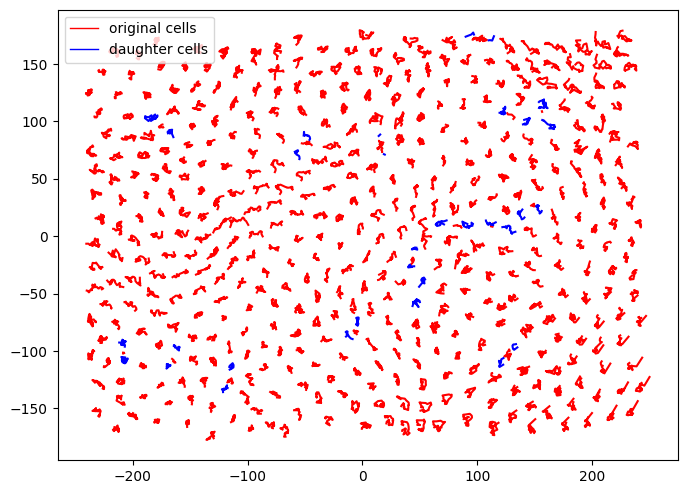

In [26]:
fig,ax=plt.subplots(figsize=(8, 8))
for i in (np.unique(dat_df.cell_id_new)):
    ax.plot(orig_cells[orig_cells.cell_id_new==i].cc_x, orig_cells[orig_cells.cell_id_new==i].cc_y, c='red', label='original cells')
    ax.plot(daughter_cells[daughter_cells.cell_id_new==i].cc_x, daughter_cells[daughter_cells.cell_id_new==i].cc_y, c='blue', label=daughter_cells)

ax.set_aspect('equal')
legend_elements = [Line2D([0], [0], color='r', lw=1, label='original cells'),
                  Line2D([0], [0], color='b', lw=1, label='daughter cells')]
ax.legend(handles=legend_elements)
plt.savefig(plot_dir+'/cell_tracks.png', dpi=300, bbox_inches='tight')

In [10]:
orig_cells.groupby('time').count().cell_id_new/(orig_cells[orig_cells.time==0].count().cell_id_new)

time
0      1.000000
5      0.997706
10     0.995413
15     0.993119
20     0.993119
25     0.990826
30     0.986239
35     0.983945
40     0.981651
45     0.979358
50     0.979358
55     0.979358
60     0.979358
65     0.979358
70     0.977064
75     0.977064
80     0.974771
85     0.970183
90     0.970183
95     0.967890
100    0.967890
105    0.967890
110    0.967890
115    0.965596
120    0.965596
125    0.965596
130    0.963303
135    0.963303
Name: cell_id_new, dtype: float64

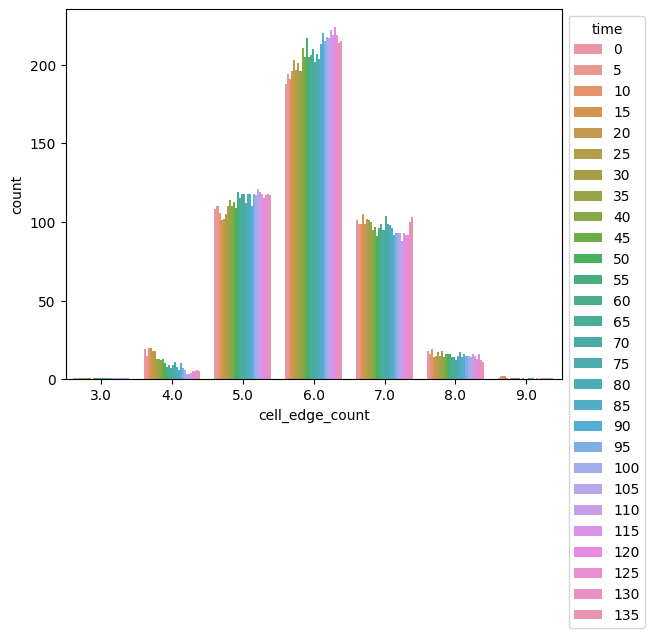

In [41]:
sns.countplot(data=dat_df,x='cell_edge_count', hue='time')
plt.legend( loc="upper left", bbox_to_anchor=(1, 1), title='time')
plt.savefig(plot_dir+'/cell_edges_hist.png', dpi=300, bbox_inches='tight')

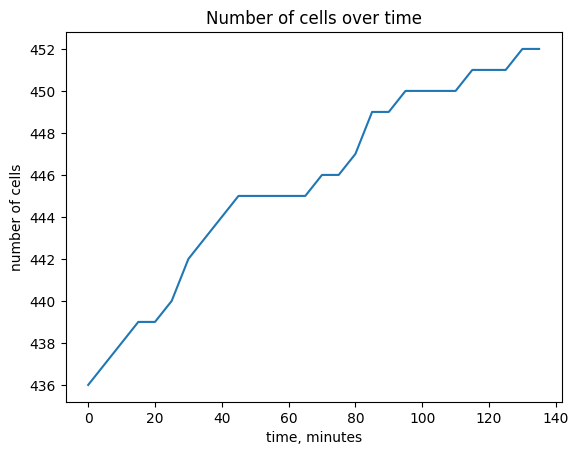

In [27]:
plt.plot(dat_df.groupby('time').count().cell_id_new)
#plt.axvline(80, c='r', linestyle='--')
plt.xlabel('time, minutes')
plt.ylabel('number of cells')
plt.title("Number of cells over time")

plt.savefig(plot_dir+'/Number_cells_time.png', dpi=300, bbox_inches='tight')

In [28]:
nd_t0=no_div[no_div.tm_frame==0][['cell_id_new','cc_x', 'cc_y', 'tm_frame']]
nd_t135=no_div[no_div.tm_frame==27][['cell_id_new','cc_x', 'cc_y', 'tm_frame']]


cc_nd=pd.merge(nd_t0, nd_t135, on='cell_id_new', suffixes=("_0", "_135"))
cc_nd['cc_dx']=cc_nd.cc_x_135-cc_nd.cc_x_0
cc_nd['cc_dy']=cc_nd.cc_y_135-cc_nd.cc_y_0



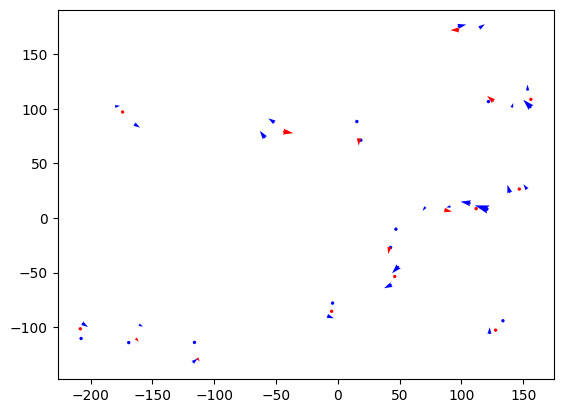

In [70]:
dc_dx=daughter_cells.groupby('cell_id_new').first().cc_x-daughter_cells.groupby('cell_id_new').last().cc_x
dc_dy=daughter_cells.groupby('cell_id_new').first().cc_y-daughter_cells.groupby('cell_id_new').last().cc_y
plt.quiver(daughter_cells.groupby('cell_id_new').first().cc_x,daughter_cells.groupby('cell_id_new').first().cc_y, dc_dx, dc_dy,units='xy', angles='xy', scale=1, zorder=10, color='blue')

div_dx=div_cells.groupby('cell_id_new').first().cc_x-div_cells.groupby('cell_id_new').last().cc_x
div_dy=div_cells.groupby('cell_id_new').first().cc_y-div_cells.groupby('cell_id_new').last().cc_y
plt.quiver(div_cells.groupby('cell_id_new').first().cc_x,div_cells.groupby('cell_id_new').first().cc_y, div_dx, div_dy,units='xy', angles='xy', scale=1, zorder=10, color='red')


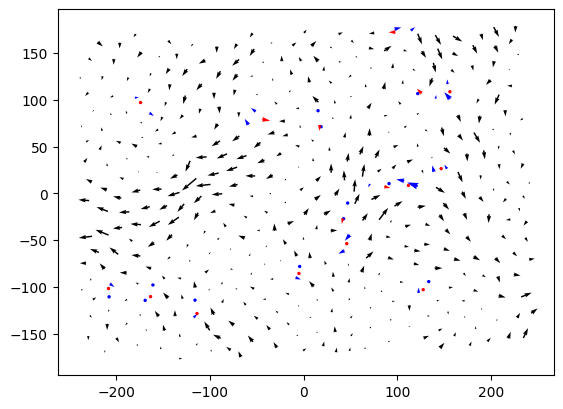

In [69]:
dx= cc_nd.cc_dx
dy=cc_nd.cc_dy


mag=np.sqrt(np.asarray(dx)**2+np.asarray(dy)**2)

plt.quiver(cc_nd.cc_x_0,cc_nd.cc_y_0, dx, dy,units='xy', angles='xy', scale=1, zorder=10)
plt.quiver(daughter_cells.groupby('cell_id_new').first().cc_x,daughter_cells.groupby('cell_id_new').first().cc_y, dc_dx, dc_dy,units='xy', angles='xy', scale=1, zorder=10, color='b')
plt.quiver(div_cells.groupby('cell_id_new').first().cc_x,div_cells.groupby('cell_id_new').first().cc_y, div_dx, div_dy,units='xy', angles='xy', scale=1, zorder=10, color='r')






#plt.quiver(cc_sr.cc_x_s,cc_sr.cc_y_s, dx, dy,units='xy', angles='xy', scale=1, zorder=10, color='red')
#plt.xlim(-200,200)
#plt.ylim(-350,350)


plt.gca().set_aspect('equal')
#plt.savefig(plot_dir+'/cell_centre_displacement.png', dpi=300, bbox_inches='tight')

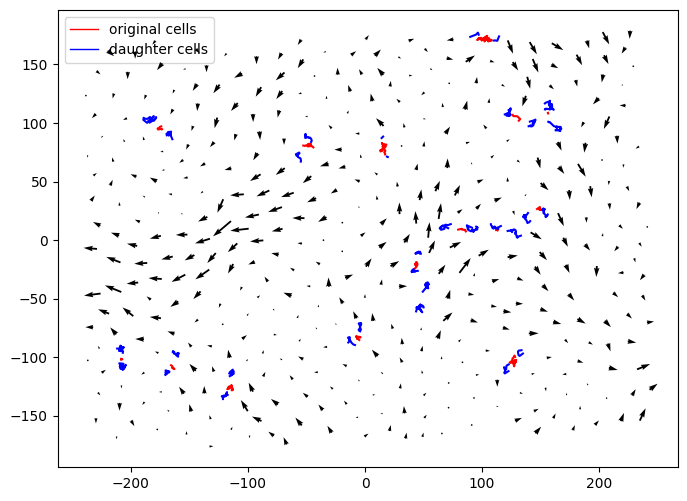

In [55]:
fig,ax=plt.subplots(figsize=(8, 8))
for i in (np.unique(dat_df.cell_id_new)):
    ax.plot(div_cells[(div_cells.cell_id_new==i)].cc_x, div_cells[(div_cells.cell_id_new==i)].cc_y, c='red', label='original cells')
    ax.plot(daughter_cells[daughter_cells.cell_id_new==i].cc_x, daughter_cells[daughter_cells.cell_id_new==i].cc_y, c='blue', label=daughter_cells)

ax.set_aspect('equal')
legend_elements = [Line2D([0], [0], color='r', lw=1, label='original cells'),
                  Line2D([0], [0], color='b', lw=1, label='daughter cells')]
ax.legend(handles=legend_elements)
ax.quiver(cc_nd.cc_x_0,cc_nd.cc_y_0, dx, dy,units='xy', angles='xy', scale=1, zorder=10)

#plt.savefig(plot_dir+'/cell_tracks_overlay.png', dpi=300, bbox_inches='tight')

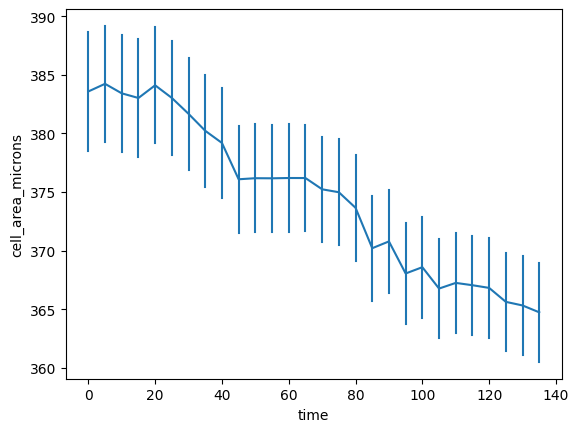

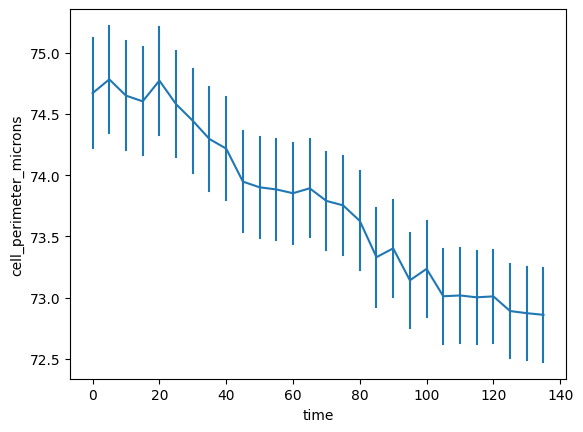

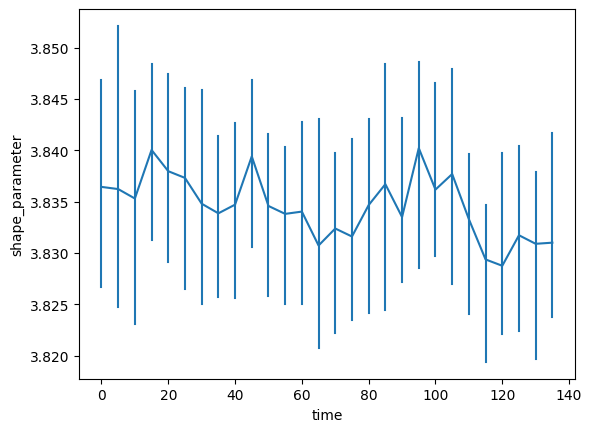

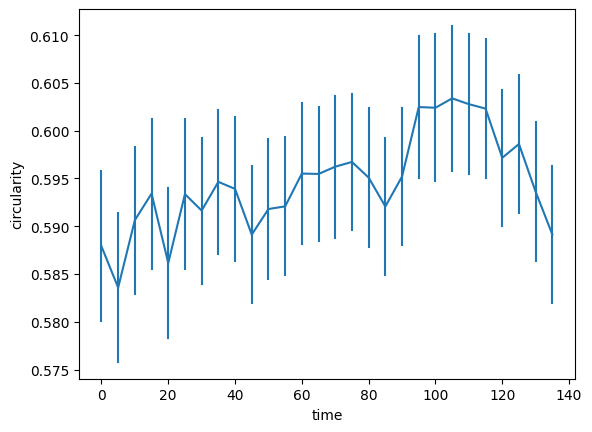

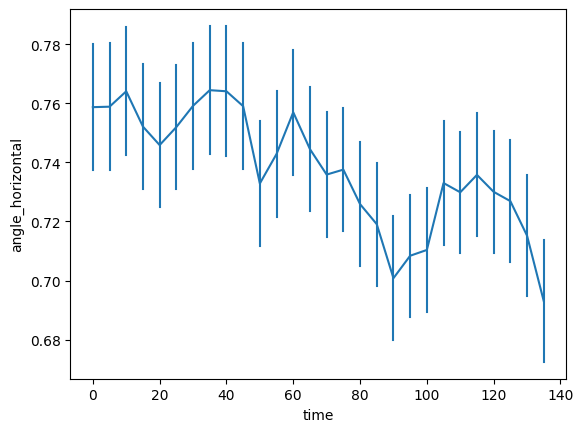

In [30]:
sns.lineplot(data=dat_df, y='cell_area_microns', x='time',err_style='bars', errorbar='se')
#plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_cell_area_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='cell_perimeter_microns', x='time',err_style='bars', errorbar='se')
#plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_cell_perimeter_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='shape_parameter', x='time',err_style='bars', estimator='median')
#plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/median_shape_parameter_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='circularity', x='time',err_style='bars', errorbar='se')
#plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_circularity_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='angle_horizontal', x='time',err_style='bars', errorbar='se')
#plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_angle_horizontal_time.png', dpi=300, bbox_inches='tight')
plt.show()

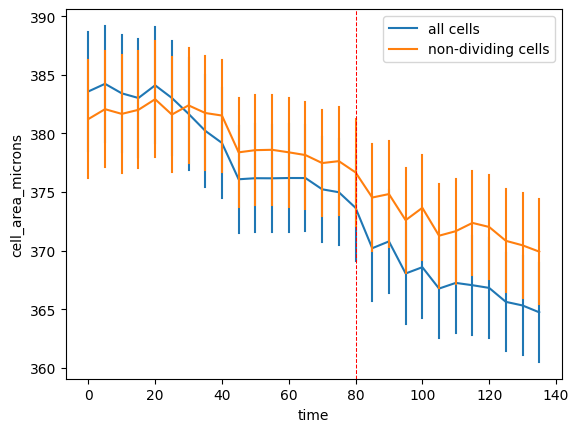

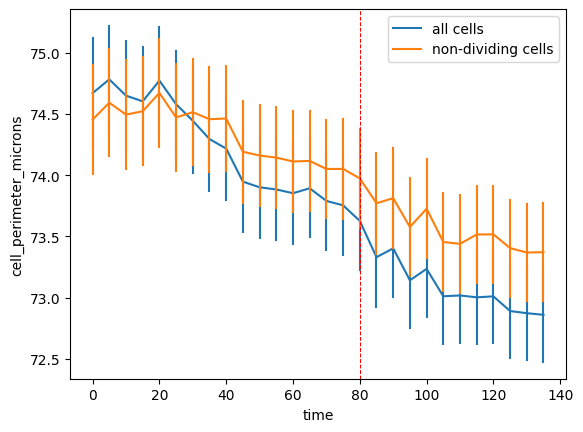

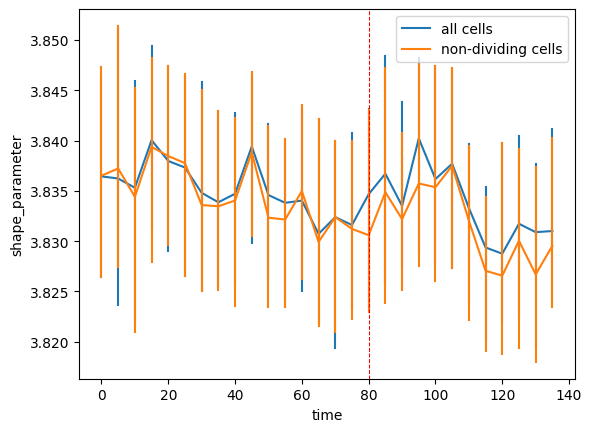

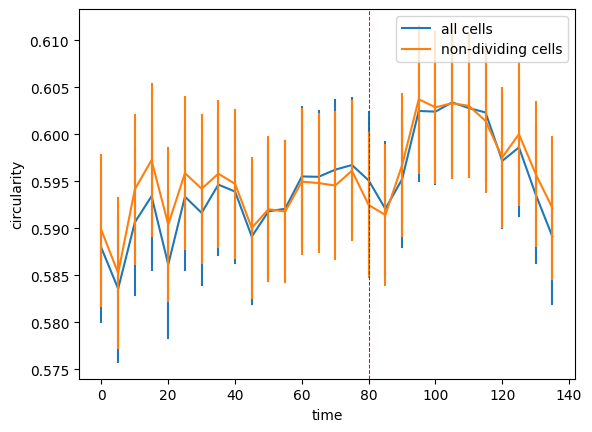

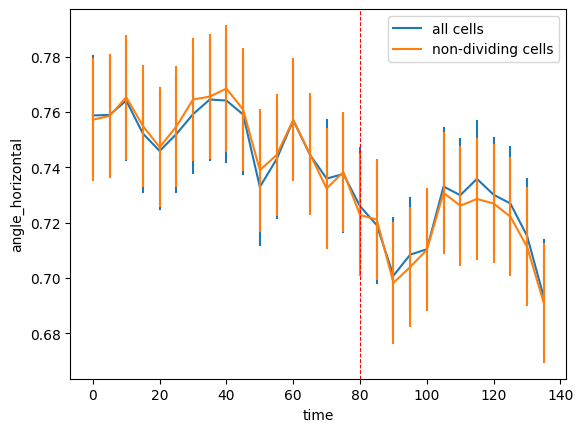

In [31]:
sns.lineplot(data=dat_df, y='cell_area_microns', x='time',err_style='bars', errorbar='se', label='all cells')
sns.lineplot(data=no_div, y='cell_area_microns', x='time',err_style='bars', errorbar='se', label='non-dividing cells')
plt.legend()
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_mean_cell_area_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='cell_perimeter_microns', x='time',err_style='bars', errorbar='se', label='all cells')
sns.lineplot(data=no_div, y='cell_perimeter_microns', x='time',err_style='bars', errorbar='se', label='non-dividing cells')
plt.legend()
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_mean_cell_perimeter_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='shape_parameter', x='time',err_style='bars', estimator='median', label='all cells')
sns.lineplot(data=no_div, y='shape_parameter', x='time',err_style='bars', estimator='median', label='non-dividing cells')
plt.legend()
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_median_shape_parameter_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='circularity', x='time',err_style='bars', errorbar='se', label='all cells')
sns.lineplot(data=no_div, y='circularity', x='time',err_style='bars', errorbar='se', label='non-dividing cells')
plt.legend()
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_mean_circularity_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='angle_horizontal', x='time',err_style='bars', errorbar='se', label='all cells')
sns.lineplot(data=no_div, y='angle_horizontal', x='time',err_style='bars', errorbar='se', label='non-dividing cells')
plt.legend()
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_mean_angle_horizontal_time.png', dpi=300, bbox_inches='tight')
plt.show()

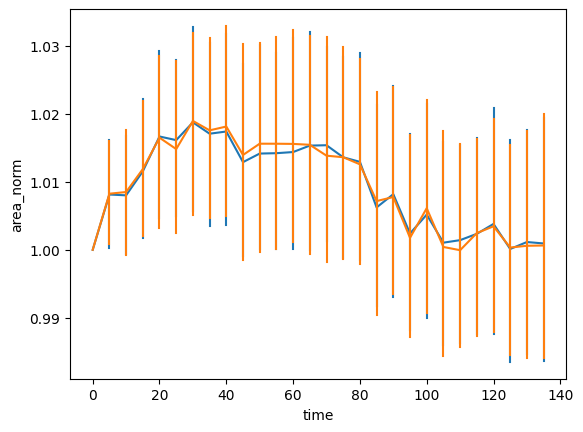

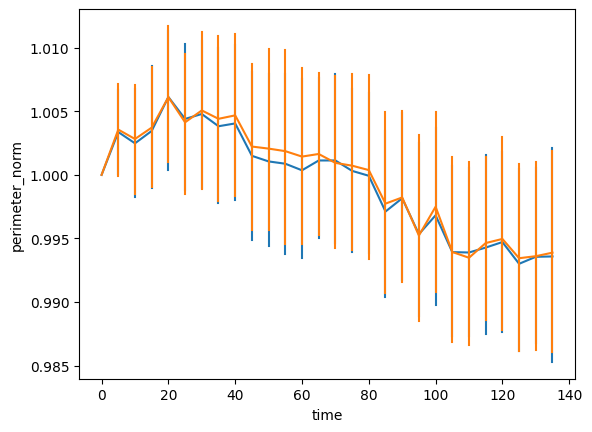

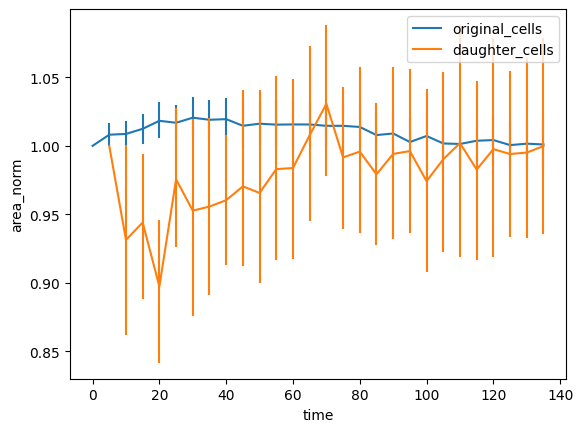

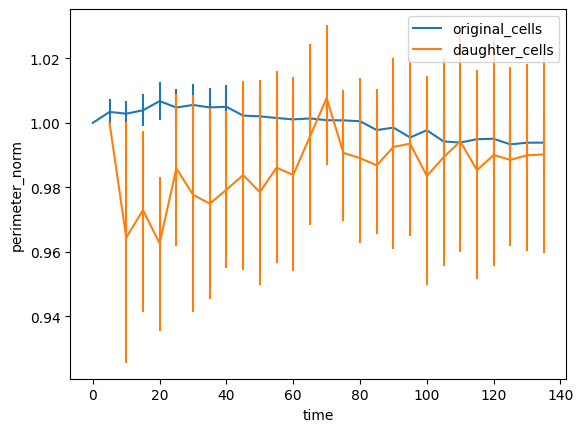

In [32]:
sns.lineplot(data=dat_df, y='area_norm', x='time',err_style='bars')
sns.lineplot(data=no_div, y='area_norm', x='time',err_style='bars')

plt.savefig(plot_dir+'/mean_area_norm_time.png', dpi=300, bbox_inches='tight')
plt.show()

sns.lineplot(data=dat_df, y='perimeter_norm', x='time',err_style='bars')
sns.lineplot(data=no_div, y='perimeter_norm', x='time',err_style='bars')

plt.savefig(plot_dir+'/mean_perimeter_norm_time.png', dpi=300, bbox_inches='tight')
plt.show()


sns.lineplot(data=orig_cells, y='area_norm', x='time',err_style='bars', label='original_cells')
sns.lineplot(data=daughter_cells, y='area_norm', x='time',err_style='bars', label='daughter_cells')
plt.legend()
plt.savefig(plot_dir+'/mean_area_norm_time_o_d.png', dpi=300, bbox_inches='tight')
plt.show()

sns.lineplot(data=orig_cells, y='perimeter_norm', x='time',err_style='bars', label='original_cells')
sns.lineplot(data=daughter_cells, y='perimeter_norm', x='time',err_style='bars', label='daughter_cells')
plt.legend()
plt.savefig(plot_dir+'/mean_perimeter_norm_time_o_d.png', dpi=300, bbox_inches='tight')
plt.show()


In [34]:
daughter_cells['aligned_time']=daughter_cells['time']-daughter_cells.groupby('cell_id_new')['time'].transform('first')

C:\Users\v35431nc\AppData\Local\Temp\ipykernel_33396\2948227597.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daughter_cells['aligned_time']=daughter_cells['time']-daughter_cells.groupby('cell_id_new')['time'].transform('first')


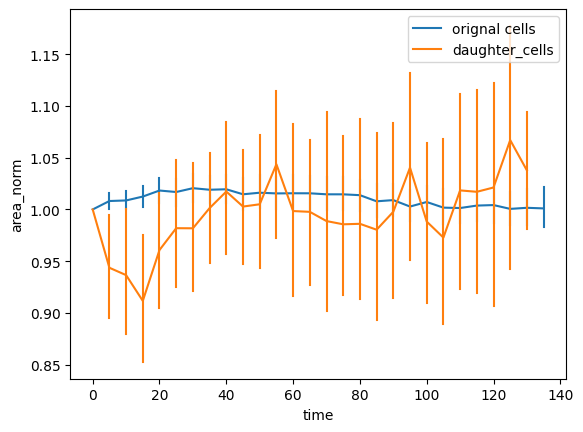

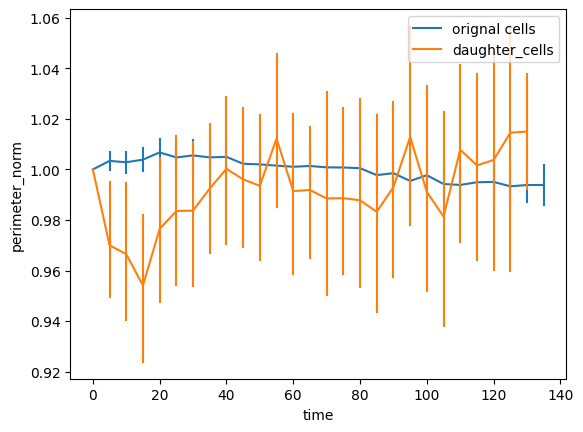

In [35]:

sns.lineplot(data=orig_cells, y='area_norm', x='time',err_style='bars', label='orignal cells')
sns.lineplot(data=daughter_cells, y='area_norm', x='aligned_time',err_style='bars', label='daughter_cells')
plt.legend()
plt.savefig(plot_dir+'/mean_area_norm_time_o_d_aligned_time.png', dpi=300, bbox_inches='tight')
plt.show()

sns.lineplot(data=orig_cells, y='perimeter_norm', x='time',err_style='bars', label='orignal cells')
sns.lineplot(data=daughter_cells, y='perimeter_norm', x='aligned_time',err_style='bars', label='daughter_cells')
plt.legend()
plt.savefig(plot_dir+'/mean_perimeter_norm_time_o_d_aligned_time.png', dpi=300, bbox_inches='tight')
plt.show()

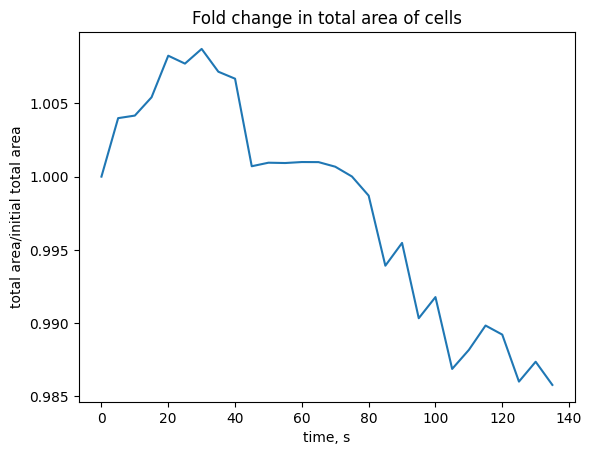

In [36]:
t=np.linspace(0, 135, 28)
plt.plot(t,dat_df.groupby('time').cell_area_microns.sum()/(dat_df[dat_df.time==0].sum().cell_area_microns))
#plt.axvline(80, linestyle='--', color='red')
plt.xlabel("time, s")
plt.ylabel("total area/initial total area")
plt.title("Fold change in total area of cells")
plt.savefig(plot_dir+'/total_area.png', dpi=300, bbox_inches='tight')

plt.show()

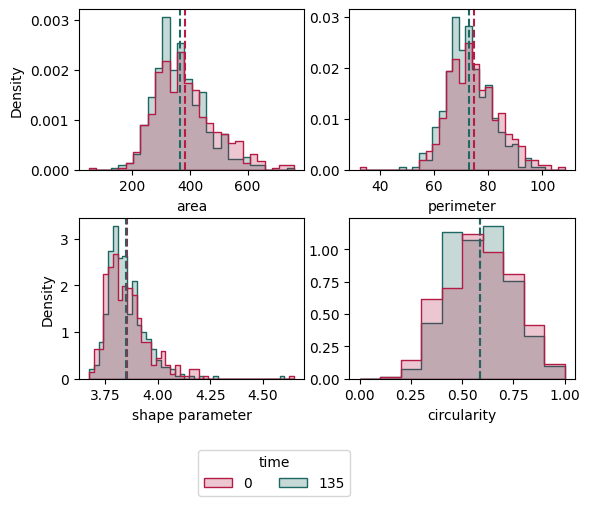

In [37]:
fig, ax=plt.subplots(2,2)
g=sns.histplot(data=dat_df[(dat_df.time ==0) | (dat_df.time==135)], hue='time',x='cell_area_microns',stat='density', element="step", palette=sns.husl_palette(2,l=.4), ax=ax[0,0], legend=False)
ax[0,0].axvline(np.mean(dat_df[dat_df.time ==0].cell_area_microns), c=sns.husl_palette(2,l=.4)[0], linestyle='--')
#ax[0,0].axvline(np.mean(dat_df[dat_df.time ==80].cell_area_microns), c=sns.husl_palette(3,l=.4)[1], linestyle='--')
ax[0,0].axvline(np.mean(dat_df[dat_df.time ==135].cell_area_microns), c=sns.husl_palette(2,l=.4)[1], linestyle='--')

g=sns.histplot(data=dat_df[(dat_df.time ==0) | (dat_df.time==135)], hue='time',x='cell_perimeter_microns',stat='density', element="step", palette=sns.husl_palette(2,l=.4), ax=ax[0,1], legend=False)
ax[0,1].axvline(np.mean(dat_df[dat_df.time ==0].cell_perimeter_microns), c=sns.husl_palette(2,l=.4)[0], linestyle='--')
#ax[0,1].axvline(np.mean(dat_df[dat_df.time ==80].cell_perimeter_microns), c=sns.husl_palette(3,l=.4)[1], linestyle='--')
ax[0,1].axvline(np.mean(dat_df[dat_df.time ==135].cell_perimeter_microns), c=sns.husl_palette(2,l=.4)[1], linestyle='--')

g=sns.histplot(data=dat_df[(dat_df.time ==0) | (dat_df.time==135)], hue='time',x='circularity', stat='density',element="step", palette=sns.husl_palette(2,l=.4), ax=ax[1,1], legend=False , binrange=[0,1], bins=10)
ax[1,1].axvline(np.mean(dat_df[dat_df.time ==0].circularity), c=sns.husl_palette(2,l=.4)[0], linestyle='--')
#ax[1,1].axvline(np.mean(dat_df[dat_df.time ==80].circularity), c=sns.husl_palette(3,l=.4)[1], linestyle='--')
ax[1,1].axvline(np.mean(dat_df[dat_df.time ==135].circularity), c=sns.husl_palette(2,l=.4)[1], linestyle='--')

g=sns.histplot(data=dat_df[(dat_df.time ==0) |(dat_df.time==135)], hue='time',x='shape_parameter', stat='density',element="step", palette=sns.husl_palette(2,l=.4), ax=ax[1,0], legend=True)
ax[1,0].axvline(np.mean(dat_df[dat_df.time ==0].shape_parameter), c=sns.husl_palette(2,l=.4)[0], linestyle='--')
#ax[1,0].axvline(np.mean(dat_df[dat_df.time ==80].shape_parameter), c=sns.husl_palette(3,l=.4)[1], linestyle='--')
ax[1,0].axvline(np.mean(dat_df[dat_df.time ==135].shape_parameter), c=sns.husl_palette(2,l=.4)[1], linestyle='--')

plt.subplots_adjust(hspace=0.3)
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')

ax[0,1].set_xlabel('perimeter')
ax[1,1].set_xlabel('circularity')
ax[1,0].set_xlabel('shape parameter')
ax[0,0].set_xlabel('area')
sns.move_legend(g, "upper left", bbox_to_anchor=(0.5, -0.4), frameon=True, ncol=3)
plt.savefig(plot_dir+'/cell_quantities_hists.png', dpi=300, bbox_inches='tight')

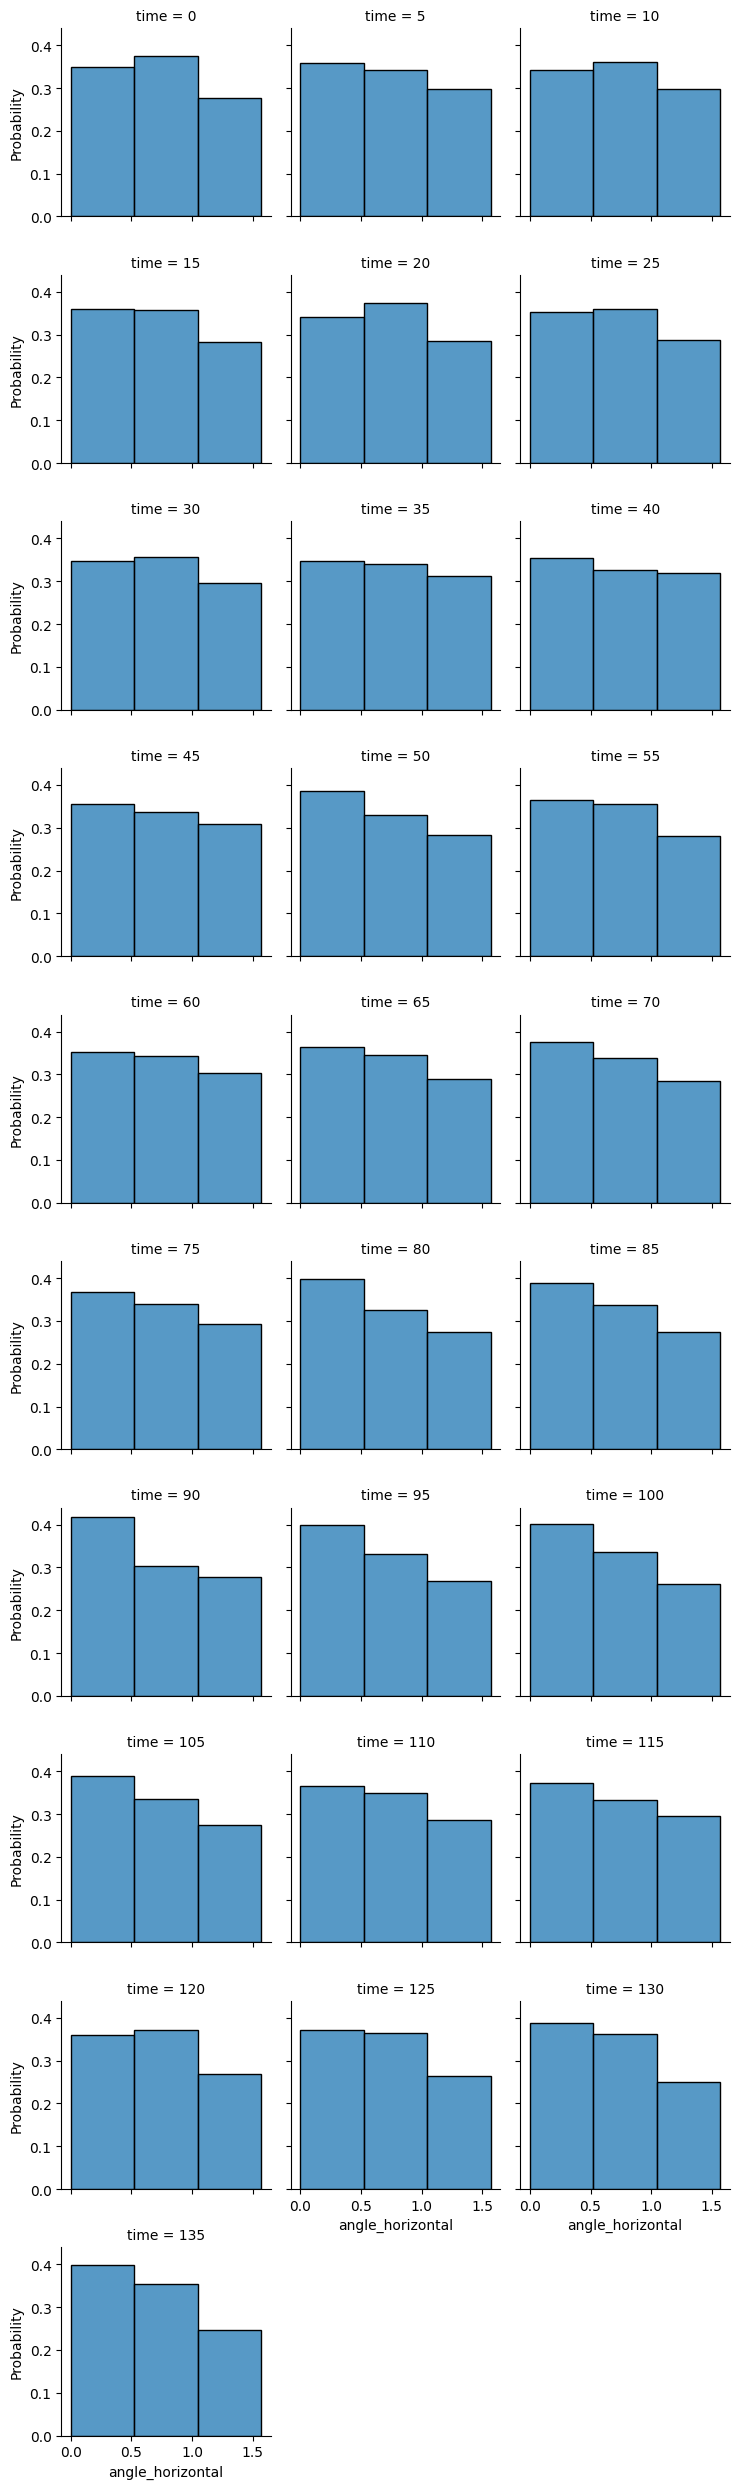

In [38]:
g = sns.FacetGrid(dat_df, col="time", height=2.5, col_wrap=3)
g.map(sns.histplot, "angle_horizontal", stat='probability', binrange=[0, np.pi/2],bins=3)

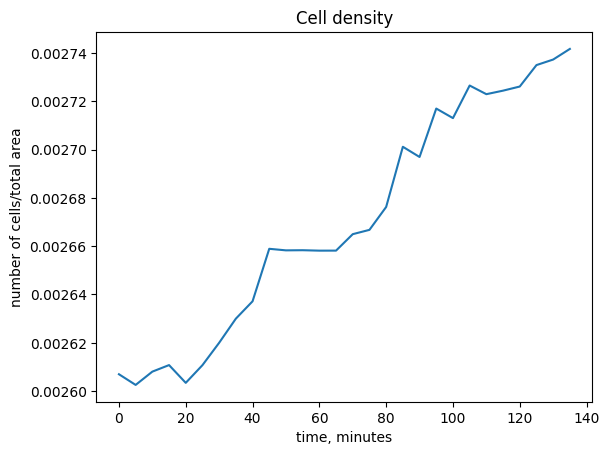

In [39]:
#cell density
plt.plot(dat_df.groupby('time').count().cell_id_new/(dat_df.groupby('time').cell_area_microns.sum()))
#plt.axvline(80, c='r', linestyle='--', linewidth=0.75)

plt.xlabel('time, minutes')
plt.ylabel('number of cells/total area')
plt.title("Cell density")

plt.savefig(plot_dir+'/cell_density_time.png', dpi=300, bbox_inches='tight')

In [40]:
dat_df['dx']=dat_df.groupby('cell_id_new').diff().cc_x
dat_df['dy']=dat_df.groupby('cell_id_new').diff().cc_y
dat_df['vtheta']=np.arctan2(dat_df.dy, dat_df.dx)
dat_df['ds']=np.sqrt(dat_df.dx**2+dat_df.dy**2)

In [106]:
vcos=np.cos(np.subtract.outer(dat_df[dat_df.time==5].vtheta.values,dat_df[dat_df.time==5].vtheta.values))

r = np.sqrt(np.subtract.outer(dat_df[dat_df.time==0].cc_x.values, dat_df[dat_df.time==0].cc_x.values)**2 +
                np.subtract.outer(dat_df[dat_df.time==0].cc_y.values, dat_df[dat_df.time==0].cc_y.values)**2)
dot_product = vcos*np.abs(np.multiply.outer(dat_df[dat_df.time==5].ds.values, dat_df[dat_df.time==5].ds.values))


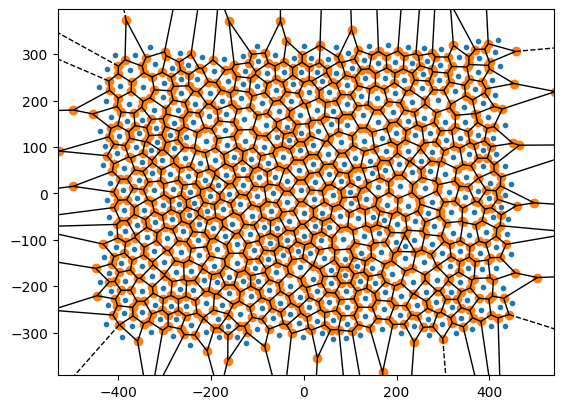

In [197]:
r0=np.array([dat_df[dat_df.time==0].cc_x.values, dat_df[dat_df.time==0].cc_y.values]).T
from scipy.spatial import Voronoi, voronoi_plot_2d
vor = Voronoi(r0)

import matplotlib.pyplot as plt
fig = voronoi_plot_2d(vor)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

plt.show()

In [140]:
cells=list(set(dat_df[dat_df.time==5].cell_id_new).intersection(set(dat_df[dat_df.time==0].cell_id_new)))
cell_corr=dat_df[(dat_df.cell_id_new.isin(cells))]
vcos=np.cos(np.subtract.outer(cell_corr[cell_corr.time==5].vtheta.values,cell_corr[cell_corr.time==5].vtheta.values))

r = np.sqrt(np.subtract.outer(cell_corr[cell_corr.time==0].cc_x.values, cell_corr[cell_corr.time==0].cc_x.values)**2 +
                np.subtract.outer(cell_corr[cell_corr.time==0].cc_y.values, cell_corr[cell_corr.time==0].cc_y.values)**2)
dot_product = vcos*np.abs(np.multiply.outer(cell_corr[cell_corr.time==5].ds.values, cell_corr[cell_corr.time==5].ds.values))


400.36039398575303

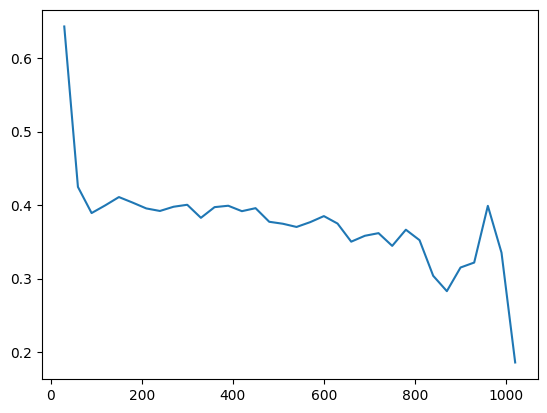

In [193]:
shape_cos=np.cos(np.subtract.outer(dat_df[dat_df.time==0].major_shape_axis_alignment_rads.values,dat_df[dat_df.time==0].major_shape_axis_alignment_rads.values))
r = np.sqrt(np.subtract.outer(dat_df[dat_df.time==0].cc_x.values, dat_df[dat_df.time==0].cc_x.values)**2 +
                np.subtract.outer(dat_df[dat_df.time==0].cc_y.values, dat_df[dat_df.time==0].cc_y.values)**2)
upper_triangle = np.triu_indices_from(r, 1)
c_func_shape=pd.DataFrame({'r': r[upper_triangle],
                        'dot_product': shape_cos[upper_triangle]})
n=101
#bins=np.linspace(c_func.r.min(),c_func.r.max(), n)
bins=np.arange(0, c_func.r.max(), 30)
shape_corr=[]
for i in range(1,len(bins)):
    c_bin=c_func_shape[(c_func_shape.r>bins[i-1])&(c_func_shape.r<=bins[i])]
    mean_corr=c_bin.dot_product.mean()
    shape_corr.append(mean_corr)

plt.plot(bins[:-1]+np.diff(bins), shape_corr)

In [191]:
np.arange(0, c_func.r.max(), 30)

array([   0.,   30.,   60.,   90.,  120.,  150.,  180.,  210.,  240.,
        270.,  300.,  330.,  360.,  390.,  420.,  450.,  480.,  510.,
        540.,  570.,  600.,  630.,  660.,  690.,  720.,  750.,  780.,
        810.,  840.,  870.,  900.,  930.,  960.,  990., 1020.])

(array([  80., 1398., 2106., 2674., 3294., 3878., 4230., 4537., 4825.,
        5069., 5231., 5207., 5181., 5112., 4982., 4764., 4484., 4178.,
        3927., 3545., 3060., 2620., 2243., 1931., 1611., 1373., 1091.,
         835.,  632.,  364.,  190.,  105.,   49.,   19.]),
 array([   0.,   30.,   60.,   90.,  120.,  150.,  180.,  210.,  240.,
         270.,  300.,  330.,  360.,  390.,  420.,  450.,  480.,  510.,
         540.,  570.,  600.,  630.,  660.,  690.,  720.,  750.,  780.,
         810.,  840.,  870.,  900.,  930.,  960.,  990., 1020.]),
 <BarContainer object of 34 artists>)

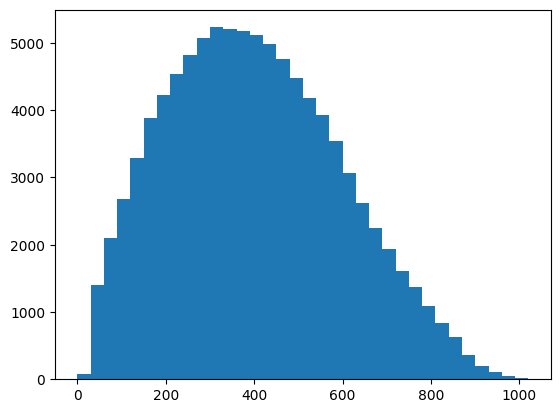

In [194]:
plt.hist(c_func_shape.r.values, bins=np.arange(0, c_func.r.max(), 30))

In [143]:
upper_triangle = np.triu_indices_from(r, 1)
c_func=pd.DataFrame({'r': r[upper_triangle],
                        'dot_product': dot_product[upper_triangle]})

<AxesSubplot: xlabel='r', ylabel='Count'>

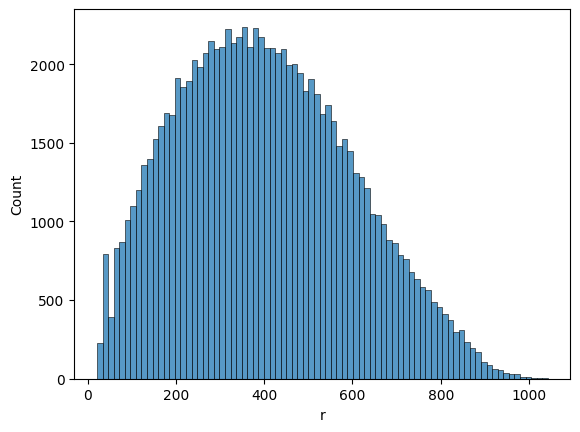

In [146]:
sns.histplot(data=c_func,x='r')

In [163]:
c_func[(c_func.r>bins[0])&(c_func.r<=bins[1])]

,r,dot_product


In [176]:
bins=np.linspace(c_func.r.min(),c_func.r.max(), 26)
c_corr=[]
for i in range(1, 26):
    c_bin=c_func[(c_func.r>bins[i-1])&(c_func.r<=bins[i])]
    mean_corr=c_bin.dot_product.mean()
    c_corr.append(mean_corr)
c_corr

[3.0332210614834576,
 2.2569741829017866,
 1.6557321351606724,
 0.9512548441876737,
 0.5058888828441718,
 0.04453852462785304,
 -0.06689865842228973,
 -0.23998017081435122,
 -0.4746189153810864,
 -0.6444873898295553,
 -0.7210967072248925,
 -0.6749598245769801,
 -0.5672234242816231,
 -0.3632709477281463,
 -0.22008128398852392,
 -0.14002230025863735,
 0.41272760717948165,
 0.5499412715449814,
 0.48085334266103086,
 0.36239502846701555,
 0.5520793340575806,
 1.0571787680119313,
 1.5980449732964856,
 3.121557580288456,
 1.7777625344372192]

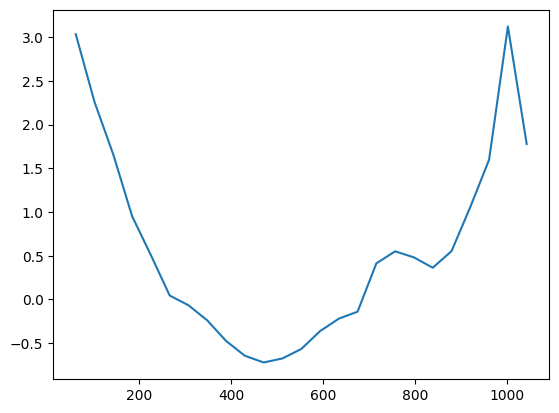

In [177]:
plt.plot(bins[:-1]+np.diff(bins), c_corr)

In [108]:
pd.DataFrame({'r': r[upper_triangle],
                        'dot_product': dot_product[upper_triangle]})

,r,dot_product
0,522.402898,-19.469460
1,456.629202,-0.904364
2,484.266498,5.415114
3,720.619463,-3.859375
4,670.631640,17.808203
...,...,...
94825,205.333445,-1.570944
94826,348.166826,NaN
94827,327.250575,0.512641
94828,806.963616,NaN


In [92]:
dat_df

,cell_id_old,cell_perimeter_microns,cell_area_microns,shape_parameter,circularity,cell_edge_count,major_shape_axis_alignment_rads,cc_x,cc_y,cell_id_new,...,time,tm_frame,parent_id,divisions,angle_horizontal,area_norm,perimeter_norm,circularity_norm,dx,dy
0,97.0,72.172974,342.299744,3.900958,0.818032,5.0,0.240503,272.727313,130.281342,0,...,0,0,NaN,0,0.240503,1.000000,1.000000,1.000000,NaN,NaN
1,350.0,83.526673,497.930465,3.743181,0.474316,7.0,2.698412,-186.158402,-119.375801,1,...,0,0,NaN,0,0.443181,1.000000,1.000000,1.000000,NaN,NaN
2,185.0,73.870311,376.705406,3.806002,0.740600,6.0,0.311762,-107.206021,-123.018658,2,...,0,0,NaN,0,0.311762,1.000000,1.000000,1.000000,NaN,NaN
3,429.0,101.522818,738.916512,3.734788,0.735775,8.0,1.436113,-211.247687,113.481342,3,...,0,0,NaN,0,1.436113,1.000000,1.000000,1.000000,NaN,NaN
4,186.0,64.218410,293.692594,3.747253,0.851626,6.0,0.479675,-404.372687,-116.351991,4,...,0,0,NaN,0,0.479675,1.000000,1.000000,1.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12472,48.0,67.030612,291.935709,3.923102,0.548599,5.0,0.948787,100.882983,-69.869056,464,...,135,27,394.0,1,0.948787,0.981299,0.992415,0.878581,0.880047,-1.620466
12473,288.0,72.867398,366.310504,3.807225,0.545824,6.0,2.050632,-85.350350,154.864278,465,...,135,27,406.0,1,1.090961,1.135209,1.043276,1.007365,-1.086619,-1.653800
12474,87.0,66.533545,297.938400,3.854583,0.651329,5.0,0.756551,-101.517017,123.930944,466,...,135,27,406.0,1,0.756551,1.385296,1.179767,0.709096,-0.319953,-1.020466
12475,293.0,62.605663,269.974648,3.810238,0.472127,6.0,0.309750,26.149650,161.197611,467,...,135,27,424.0,1,0.309750,0.823214,0.907093,0.902947,-2.419953,-2.320466


In [1]:
daughter_cells['aligned_time']=daughter_cells['time']-daughter_cells.groupby('cell_id_new')['time'].transform('first')

NameError: name 'daughter_cells' is not defined

In [ ]:

sns.lineplot(data=orig_cells, y='area_norm', x='time',err_style='bars',label='original cells')
sns.lineplot(data=daughter_cells, y='area_norm', x='aligned_time',err_style='bars', label='daughter_cells')
plt.axhline(1, linestyle='--', color='lightgrey', linewidth=0.75)
plt.title('meam')
plt.legend()
plt.savefig(plot_dir+'/mean_area_norm_time_o_d_time_aligned.png', dpi=300, bbox_inches='tight')
plt.show()

sns.lineplot(data=orig_cells, y='perimeter_norm', x='time',err_style='bars',label='original cells')
sns.lineplot(data=daughter_cells, y='perimeter_norm', x='aligned_time',err_style='bars', label='daughter_cells')
plt.axhline(1, linestyle='--', color='lightgrey', linewidth=0.75)
plt.title('mean')
plt.legend()
plt.savefig(plot_dir+'/mean_perimeter_norm_time_o_d_time_aligned.png', dpi=300, bbox_inches='tight')
plt.show()

sns.lineplot(data=orig_cells, y='area_norm', x='time',err_style='bars',label='original cells', estimator='median')
sns.lineplot(data=daughter_cells, y='area_norm', x='aligned_time',err_style='bars', estimator='median',label='daughter_cells')
plt.axhline(1, linestyle='--', color='lightgrey', linewidth=0.75)
plt.title('median')
plt.legend()
plt.savefig(plot_dir+'/median_area_norm_time_o_d_time_aligned.png', dpi=300, bbox_inches='tight')
plt.show()

sns.lineplot(data=orig_cells, y='perimeter_norm', x='time',err_style='bars', estimator='median', label='original cells')
sns.lineplot(data=daughter_cells, y='perimeter_norm', x='aligned_time',err_style='bars',estimator='median', label='daughter_cells')
plt.axhline(1, linestyle='--', color='lightgrey', linewidth=0.75)
plt.title('median')
plt.legend()
plt.savefig(plot_dir+'/median_perimeter_norm_time_o_d_time_aligned.png', dpi=300, bbox_inches='tight')
plt.show()

In [1]:
dat_df

NameError: name 'dat_df' is not defined